In [1]:
!pip install torch==2.2.1

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F


In [57]:

# Define model
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, h2_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)   # first fully connected layer
        self.fc2 = nn.Linear(h1_nodes, h2_nodes)   # second fully connected layer
        self.out = nn.Linear(h2_nodes, out_actions) # ouptut layer w

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Apply rectified linear unit (ReLU) activation
        x = F.relu(self.fc2(x)) # Apply rectified linear unit (ReLU) activation
        x = self.out(x)         # Calculate output
        return x


class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)


class MountainCarDQL():
    # Hyperparameters (adjustable)
    learning_rate_a = 0.001         # learning rate (alpha)
    discount_factor_g = 0.99         # discount rate (gamma)    
    network_sync_rate = 5000          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 100000       # size of replay memory
    mini_batch_size = 64            # size of the training data set sampled from the replay memory
    
    num_divisions = 30

    # Neural Network
    loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None                # NN Optimizer. Initialize later.


    # Train the environment
    def train(self, episodes, render=False, load_path = None):
        # Create FrozenLake instance
        env = gym.make('CartPole-v0', render_mode='human' if render else None)
        num_states = 4#env.observation_space.shape[0] # expecting 2: position & velocity
        num_actions = env.action_space.n

        # Divide position and velocity into segments
        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07
        self.pos_space1 = np.linspace(env.observation_space.low[2], env.observation_space.high[2], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space1 = np.linspace(env.observation_space.low[3], env.observation_space.high[3], self.num_divisions)    # Between -0.07 and 0.07
    
        epsilon = 0.6 
        memory = ReplayMemory(self.replay_memory_size)

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = DQN(in_states=num_states, h1_nodes=64, h2_nodes = 64, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=64, h2_nodes = 64, out_actions=num_actions)

        # Make the target and policy networks the same (copy weights/biases from one network to the other)
        if (load_path!=None):
            policy_dqn.load_state_dict(torch.load(load_path))
            
        target_dqn.load_state_dict(policy_dqn.state_dict())
        
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        rewards_per_episode = []
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0
        goal_reached=False
        best_rewards=-200

        update_net_cnt = 0
        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False   
            truncated = False
            rewards = 0

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):

                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample() # actions: 0=left,1=idle,2=right
                else:
                    # select best action            
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                new_state,reward,terminated,truncated,_ = env.step(action)

                if truncated:
                    reward = 2
                if terminated:
                    reward = -2

                rewards += reward

                memory.append((state, action, new_state, reward, terminated)) 

                state = new_state

                step_count+=1


            rewards_per_episode.append(rewards)
            if(terminated):
                goal_reached = True

            # Graph training progress
            if(i!=0 and i%1000==0):
                print(f'Episode {i} Epsilon {epsilon}')
                                        
                self.plot_progress(rewards_per_episode, epsilon_history)
            
            #print('episode: ', i, ' time: ', rewards)
            if rewards>best_rewards:
                best_rewards = rewards
                print(f'Best rewards so far: {best_rewards}, epsilon {epsilon}')
                # Save policy
                torch.save(policy_dqn.state_dict(), f"CartPole_dql_{i}.pt")


                
            # Check if enough experience has been collected
            if len(memory)>self.mini_batch_size and goal_reached:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)
                if (update_net_cnt % 2 == 0):
                    # Decay epsilon
                    epsilon *= 0.9999
                    epsilon = max(epsilon, 0.1)
                #max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)
                update_net_cnt+=1

                

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0                    

        env.close()
        torch.save(policy_dqn.state_dict(), f"CartPole_dql_last.pt")
    
    def plot_progress(self, rewards_per_episode, epsilon_history):
        # Create new graph 
        plt.figure(1)

        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        plt.plot(rewards_per_episode)
        
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)
        
        plt.savefig('CartPole_dql.png')
        

    def optimize(self, mini_batch, policy_dqn, target_dqn):
        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated: 
                target = torch.FloatTensor([reward])
            else:
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state)).max()
                    )

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state)) 
            
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)
                
        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    '''
    Converts a state (position, velocity) to tensor representation.
    Example:
    Input = (0.3, -0.03)
    Return = tensor([16, 6])
    '''
    def state_to_dqn_input(self, state)->torch.Tensor:
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)
        state_p1 = np.digitize(state[2], self.pos_space1)
        state_v1 = np.digitize(state[3], self.vel_space1)
        return torch.FloatTensor([state_p, state_v, state_p1, state_v1])
    

    def test(self, episodes, model_filepath):
        # Create FrozenLake instance
        env = gym.make('CartPole-v0', render_mode='human')
        num_states = 4 #env.observation_space.shape[0]
        num_actions = env.action_space.n

        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07
        self.pos_space1 = np.linspace(env.observation_space.low[2], env.observation_space.high[2], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space1 = np.linspace(env.observation_space.low[3], env.observation_space.high[3], self.num_divisions)    # Between -0.07 and 0.07
    
        # Load learned policy
        policy_dqn = DQN(in_states=num_states, h1_nodes=64, h2_nodes=64, out_actions=num_actions) 
        policy_dqn.load_state_dict(torch.load(model_filepath))
        policy_dqn.eval()    # switch model to evaluation mode
        
        
        for i in range(episodes):
            state, _ = env.reset()
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions            
            cnt = 0
            while(not terminated and not truncated):  
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)
                cnt+=1
            print(cnt)
        env.close()



In [58]:
mountaincar = MountainCarDQL()

Best rewards so far: 28.0, epsilon 0.6
Best rewards so far: 35.0, epsilon 0.6
Best rewards so far: 50.0, epsilon 0.5993403299010198
Best rewards so far: 56.0, epsilon 0.5988610254188326
Best rewards so far: 74.0, epsilon 0.5988011393162906
Best rewards so far: 81.0, epsilon 0.597485159118711
Best rewards so far: 87.0, epsilon 0.5974254106027992
Best rewards so far: 144.0, epsilon 0.595516609557824
Episode 1000 Epsilon 0.5707362277629482
Best rewards so far: 163.0, epsilon 0.5468229168993903
Episode 2000 Epsilon 0.542899736135133
Episode 3000 Epsilon 0.5164209124254431
Episode 4000 Epsilon 0.491233539159329
Episode 5000 Epsilon 0.46727462848406326
Episode 6000 Epsilon 0.444484264650546
Best rewards so far: 171.0, epsilon 0.4382168784776953
Episode 7000 Epsilon 0.4228054541777346
Best rewards so far: 177.0, epsilon 0.4120772653252194
Episode 8000 Epsilon 0.40218398332500077
Episode 9000 Epsilon 0.3825682825159799


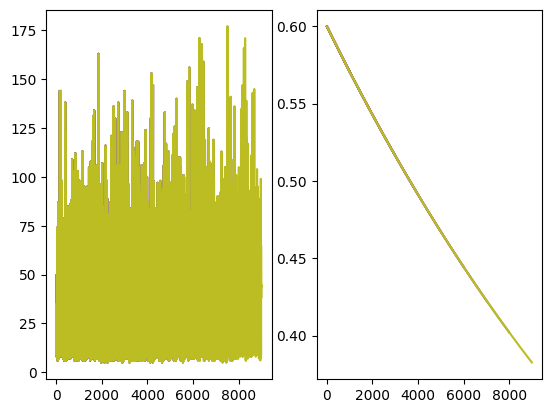

In [55]:
mountaincar.train(10_000, False, 'CartPole_dql_last.pt')

In [59]:
mountaincar.test(10, 'CartPole_dql_last.pt') 

42
51
52
64
45
41
41
60
27
34


In [61]:
env = gym.make('CartPole-v0', render_mode='human')
num_states = 4 #env.observation_space.shape[0]
num_actions = env.action_space.n


# Load learned policy
policy_dqn = DQN(in_states=num_states, h1_nodes=64, h2_nodes=64, out_actions=num_actions) 
#policy_dqn.load_state_dict(torch.load(model_filepath))
policy_dqn.eval()    # switch model to evaluation mode


for i in range(episodes):
    state, _ = env.reset()
    terminated = False      # True when agent falls in hole or reached goal
    truncated = False       # True when agent takes more than 200 actions            
    cnt = 0
    while(not terminated and not truncated):  
        with torch.no_grad():
            action = env.action_space().sample() #policy_dqn(self.state_to_dqn_input(state)).argmax().item()

        # Execute action
        state,reward,terminated,truncated,_ = env.step(action)
        cnt+=1
    print(cnt)
env.close()

NameError: name 'episodes' is not defined